# Assignment — Centrality measures

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import requests
from scipy.sparse import csr_matrix
from typing import Dict, List
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.csgraph import reverse_cuthill_mckee
import seaborn as sns
import numpy as np

### Metro dataset

In this assignment, we will use Moscow Metro underground stations dataset taken from [Moscow Subway Optimal* Complete Route](https://medium.com/altsoph/moscow-subway-optimal-complete-route-ac98796dd652) research. Let us download and take a look at the data.

In [2]:
station_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/stations_data.txt'
routes_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/routes_data.txt'

In [3]:
stations = pd.read_csv(station_url)
routes = pd.read_csv(routes_url)

In [5]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Sokolnicheskaya,Bulvar Rokossovskogo,deadend,120,90,360,55.814269,37.735117
1,1,Sokolnicheskaya,Cherkizovskaya,pass,120,90,360,55.802991,37.744825
2,2,Sokolnicheskaya,Preobrazhenskaya ploschad,pass,120,90,360,55.796172,37.715022
3,3,Sokolnicheskaya,Sokolniki,pass,120,90,360,55.789200,37.679706
4,4,Sokolnicheskaya,Krasnoselskaya,pass,120,90,360,55.779853,37.666077


In [6]:
routes.head()

,id_from,id_to,route_type,delay
0,0,1,drive,120
1,1,0,drive,120
2,1,2,drive,240
3,2,1,drive,240
4,2,3,drive,180


### Task 1. Metro graph (0.0 points)

Before we start analyzing centrality, let us build a graph of stations.

Write a function `metro_graph` that takes datasets `stations` and `routes` and returns a graph with all stations and routes of any type. Labels of nodes are in column `stations.id`. Nodes in `G.nodes` viewer should be in ascending order. All nodes should have attributes `station_name` and `line_name`.

In [7]:
def metro_graph(stations: pd.DataFrame, routes: pd.DataFrame) -> nx.Graph:
    """
    Build a graph with metro stations and routes
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph
    :param routes: edgelist for undeground graph. id_from is source and id_to is target nodes.
    :return: graph of Moscow undeground
    """
    G = nx.Graph()
    G.add_nodes_from(stations.id.values)
    G.add_edges_from(routes.loc[:, ['id_from', 'id_to']].values)
    nx.set_node_attributes(G, stations.station_name.to_dict(), 'station_name')
    nx.set_node_attributes(G, stations.line_name.to_dict(), 'line_name')
    return G

In [8]:
'''Check ordering of nodes, number of nodes, names of stations and lines'''
G = metro_graph(stations, routes)
assert (np.array(list(G.nodes)) == np.arange(194)).sum() == 194
assert G.number_of_edges() == 228
assert G.nodes[100]['station_name'] == 'Shabolovskaya'
assert G.nodes[100]['line_name'] == 'Kaluzhsko-Rizhskaya'

Let us draw the graph with default spring layout.

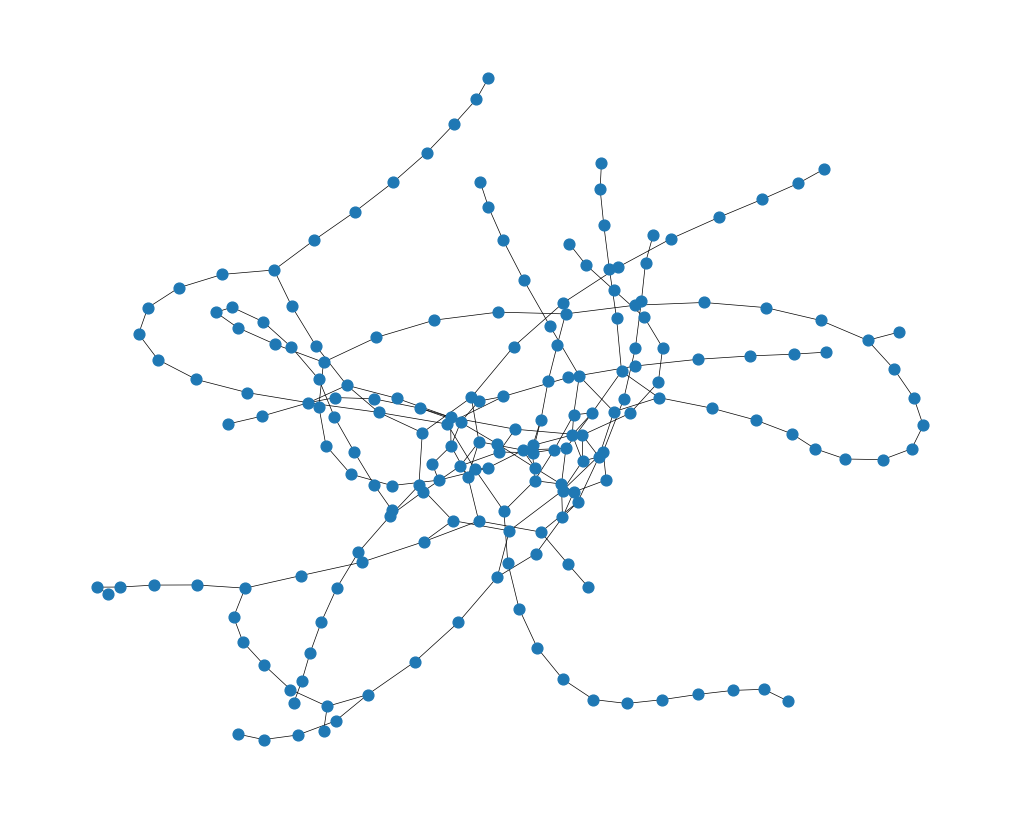

In [9]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        width=0.5,
        node_size=60)
plt.show()

So far it does not look like a metro map. Let us specify a distance based layout using information from the dataset `stations`.

Write a function `metro_layout` that takes the dataset `stations` and returns a dictionary with nodes as keys and positions as values:
```
{node_id: [longitude, latitude]}
```

In [10]:
def metro_layout(stations: pd.DataFrame) -> Dict[int, List[float]]:
    """
    Build a distance based layout of the metro graph
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph.
        lat and lon is geo coordinates of station.
    :return: geo layout of Moscow undeground
    """
    _metro_layout = {}
    for i in range(stations.shape[0]):
        _metro_layout[i] = stations.loc[i, ['lon', 'lat']].tolist()
    return _metro_layout

In [11]:
'''Check a type and positions of some random nodes'''
pos = metro_layout(stations)
assert type(pos) == dict
assert len(pos) == 194
assert pos[100] == [37.6078018, 55.71882329]
assert pos[172] == [37.72840065, 55.69297728]

Let us draw the graph with the distance based layout.

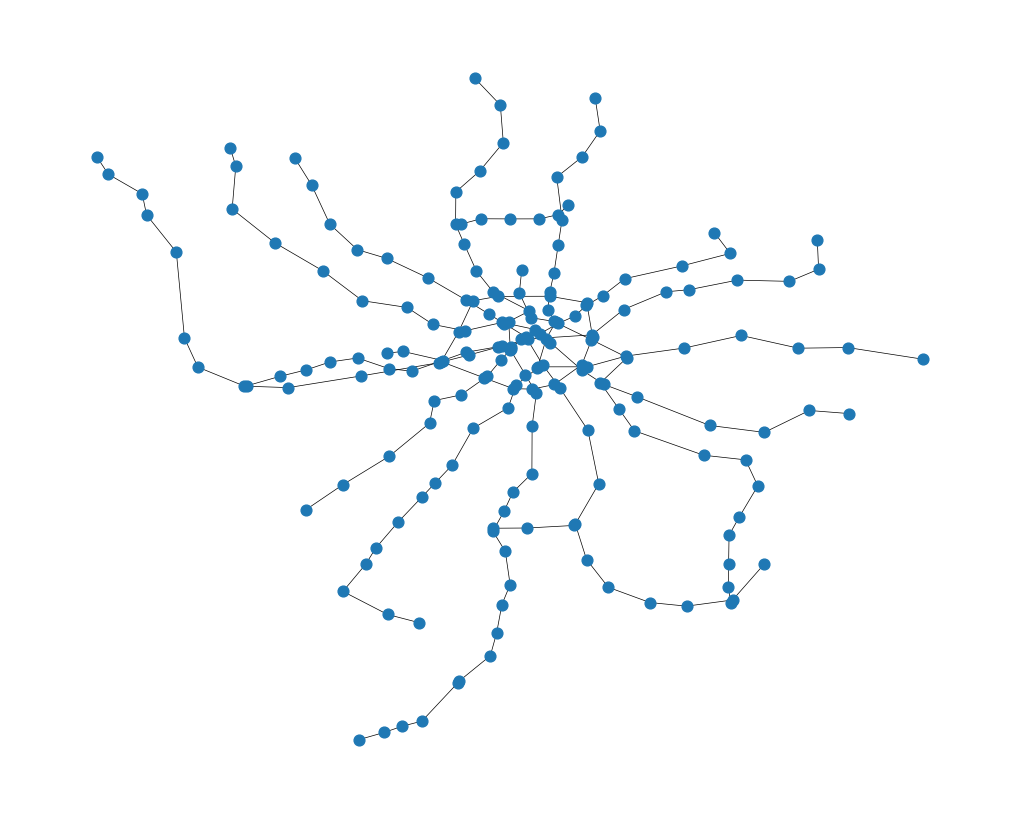

In [12]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        pos,
        width=0.5,
        node_size=60)
plt.show()

The final preprocessing step, let us colorize stations by their lines.

Write a function `station_color` that takes a graph `G` and returns a dictionary with nodes as keys and color as values. Colors are given in the `line_color` dictionary.

In [13]:
line_color = {
    'Sokolnicheskaya': 'tab:red',
    'Zamoskvoretskaya': 'tab:green',
    'Arbatsko-Pokrovskaya': 'tab:blue',
    'Filevskaya': 'deepskyblue',
    'Koltsevaya': 'tab:brown',
    'Kaluzhsko-Rizhskaya': 'tab:orange',
    'Tagansko-Krasnopresnenskaya': 'tab:purple', 
    'Kalininskaya': 'gold',
    'Serpuhovsko-Timiryazevskaya': 'gray', 
    'Lyublinsko-Dmitrovskaya': 'yellowgreen',
    'Kahovskaya': 'paleturquoise', 
    'Butovskaya': 'lightblue', 
    'Monorels': 'royalblue'
}

In [14]:
def station_color(G: nx.Graph, line_color: Dict[str, str] = line_color) -> Dict[int, str]:
    """
    Defines color of stations
    
    :param G: graph of Moscow undeground
    :param line_color: mapping of undeground lines to colors
    :return: mapping of node ids to its colors 
    """
    color = {}
    for node in G.nodes:
        color[node] = line_color[G.nodes[node]['line_name']]
    return color

In [15]:
'''Check a type and colors of some random nodes'''
nx.set_node_attributes(G, station_color(G), 'color')
assert type(station_color(G)) == dict
assert len(station_color(G)) == 194
assert station_color(G)[9] == 'tab:red'
assert station_color(G)[193] == 'royalblue'
assert station_color(G)[119] == 'tab:purple'

Let us draw the graph with the distance based layout and stations colors.

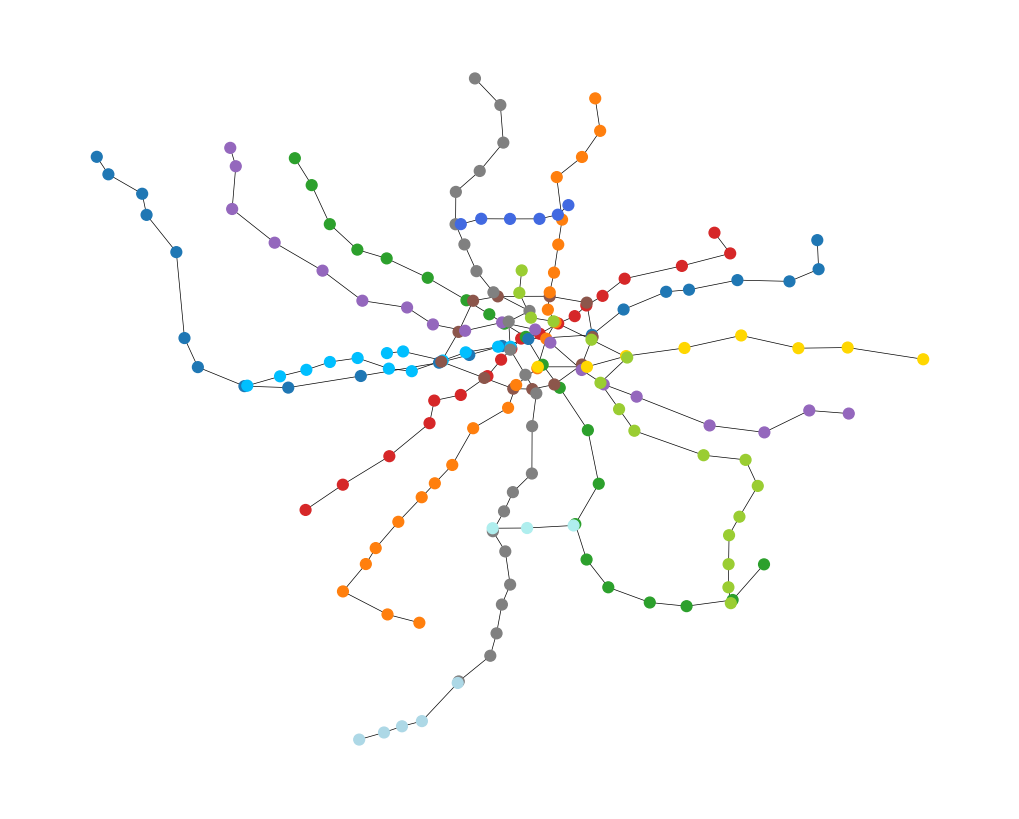

In [16]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.show()

### Task 2. Degree and closeness and betweenness centralities (0.0 points)

Let us look at centrality measures of the metro stations graph. First, use networkx to calculate degree, closeness, betweenness centralities.

Write a function `centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are np.arrays with values of each centrality.

In [17]:
def centralities(G: nx.Graph) -> Dict[str, np.array]:
    """
    Calculate degree, closeness, betweenness centralities of the graph
    
    :param G: Moscow undeground graph
    :return: mapping of centrality names (degree, closeness, betweenness) to np.array of its values
    """
    cent = {}
    cent = {
        'degree': np.array(list(nx.degree_centrality(G).values())),
        'closeness': np.array(list(nx.closeness_centrality(G).values())),
        'betweenness': np.array(list(nx.betweenness_centrality(G).values()))
    }
    return cent

In [18]:
'''Check some random values of centralities'''
c = centralities(G)
assert c['degree'].shape[0] == 194
assert c['degree'][193] == 0.0051813471502590676
assert c['closeness'][94] == 0.12107904642409034
assert c['betweenness'][49] == 0.0991400402993669

Next, let us create a table with top 10 nodes for each centrality.

Write a function `top10_centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are pd.DataFrames with columns:
* `station` — station name
* `line` — line name
* `centrality` — value of a centrality

Each dataframe contains 10 rows with highest centrality values.

In [19]:
def top10_centralities(G: nx.Graph) -> Dict[str, pd.DataFrame]:
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities
    
    :param G: graph of Moscow undeground
    :return: mapping of station name to the dataframe with columns (station, line, centrality)
    """
    degree_cent = nx.degree_centrality(G)
    closeness_cent = nx.closeness_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    station = []
    line = []
    degree_centrality = []
    closeness_centrality = []
    betweenness_centrality = []
    for node in G.nodes:
        station.append(G.nodes[node]['station_name'])
        line.append(G.nodes[node]['line_name'])
        degree_centrality.append(degree_cent[node])
        closeness_centrality.append(closeness_cent[node])
        betweenness_centrality.append(betweenness_cent[node])
    df_degree_cent = pd.DataFrame(
        {
            'station': station,
            'line': line,
            'centrality': degree_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    df_closeness_cent = pd.DataFrame(
        {
            'station': station,
            'line': line,
            'centrality': closeness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    df_betweenness_cent = pd.DataFrame(
        {
            'station': station,
            'line': line,
            'centrality': betweenness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(10)
    top10 = {
        'degree': df_degree_cent,
        'closeness': df_closeness_cent,
        'betweenness': df_betweenness_cent
    }
    return top10

In [20]:
'''Check that some random nodes are in the top 10 tables'''
top_dfs = top10_centralities(G)
assert 'Biblioteka imeni Lenina' in top_dfs['degree']['station'].to_list()
assert 'Serpuhovskaya' in top_dfs['betweenness']['station'].to_list()
assert 'Teatralnaya' in top_dfs['closeness']['station'].to_list()
assert 'Arbatsko-Pokrovskaya' in top_dfs['closeness']['line'].to_list()

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

Degree centrality


,station,line,centrality
69,Kievskaya,Filevskaya,0.025907
49,Arbatskaya,Arbatsko-Pokrovskaya,0.025907
10,Biblioteka imeni Lenina,Sokolnicheskaya,0.025907
149,Borovitskaya,Serpuhovsko-Timiryazevskaya,0.020725
123,Taganskaya,Tagansko-Krasnopresnenskaya,0.020725
28,Teatralnaya,Zamoskvoretskaya,0.020725
27,Tverskaya,Zamoskvoretskaya,0.020725
79,Taganskaya,Koltsevaya,0.020725
80,Kurskaya,Koltsevaya,0.020725
148,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.020725


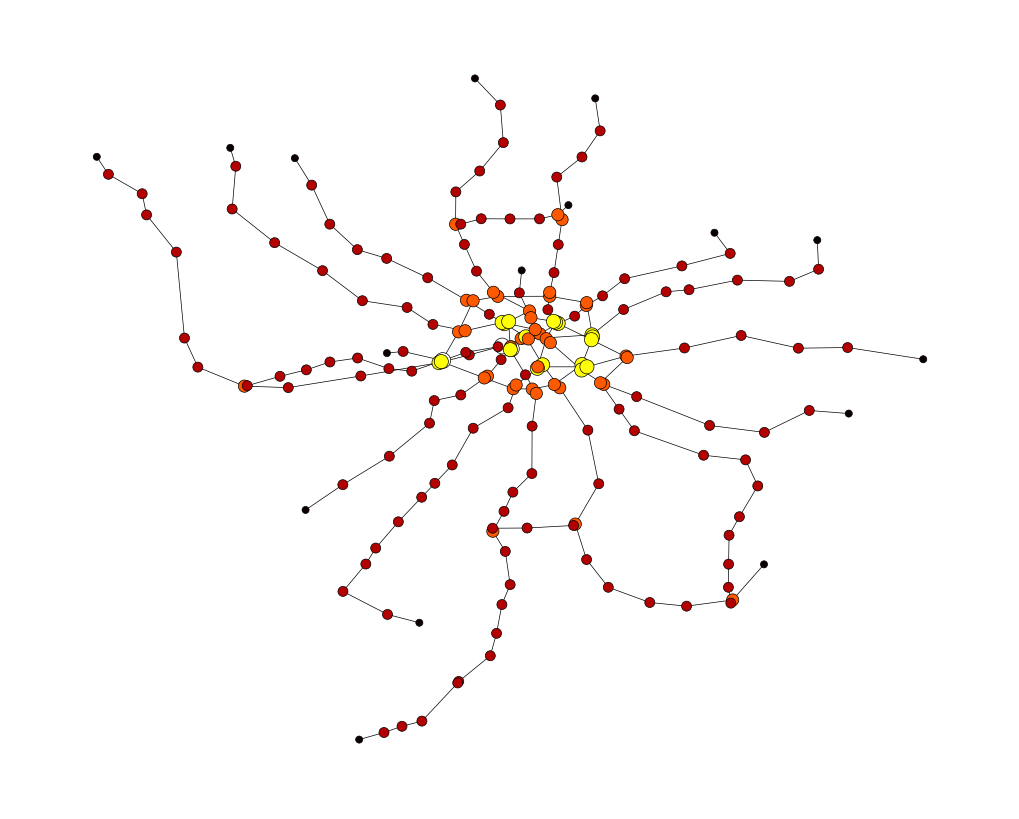

Closeness centrality


,station,line,centrality
28,Teatralnaya,Zamoskvoretskaya,0.141288
48,Ploschad Revolyutsii,Arbatsko-Pokrovskaya,0.141185
29,Novokuznetskaya,Zamoskvoretskaya,0.139350
80,Kurskaya,Koltsevaya,0.138849
79,Taganskaya,Koltsevaya,0.138849
49,Arbatskaya,Arbatsko-Pokrovskaya,0.138451
148,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.137956
78,Paveletskaya,Koltsevaya,0.137857
77,Dobryninskaya,Koltsevaya,0.137464
98,Tretyakovskaya,Kaluzhsko-Rizhskaya,0.137269


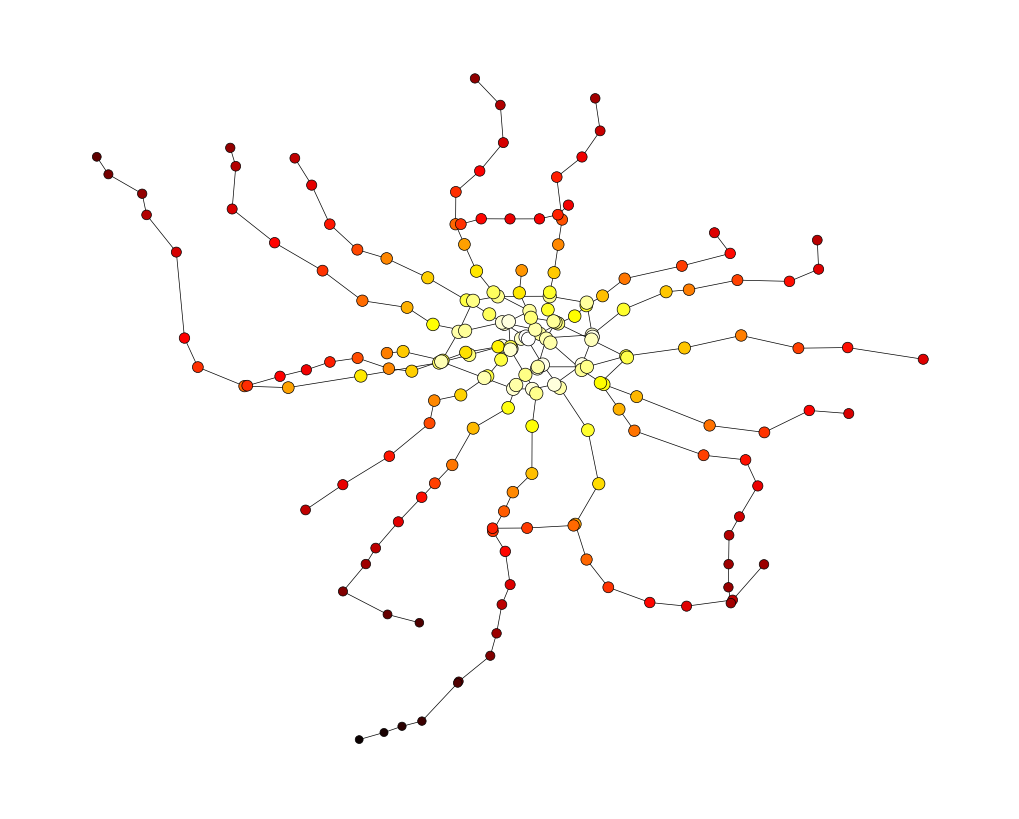

Betweenness centrality


,station,line,centrality
86,Kievskaya,Koltsevaya,0.172276
151,Serpuhovskaya,Serpuhovsko-Timiryazevskaya,0.144095
51,Kievskaya,Arbatsko-Pokrovskaya,0.133394
152,Tulskaya,Serpuhovsko-Timiryazevskaya,0.130192
75,Park kultury,Koltsevaya,0.130139
77,Dobryninskaya,Koltsevaya,0.129763
76,Oktyabrskaya,Koltsevaya,0.124274
99,Oktyabrskaya,Kaluzhsko-Rizhskaya,0.122584
153,Nagatinskaya,Serpuhovsko-Timiryazevskaya,0.122204
85,Krasnopresnenskaya,Koltsevaya,0.122121


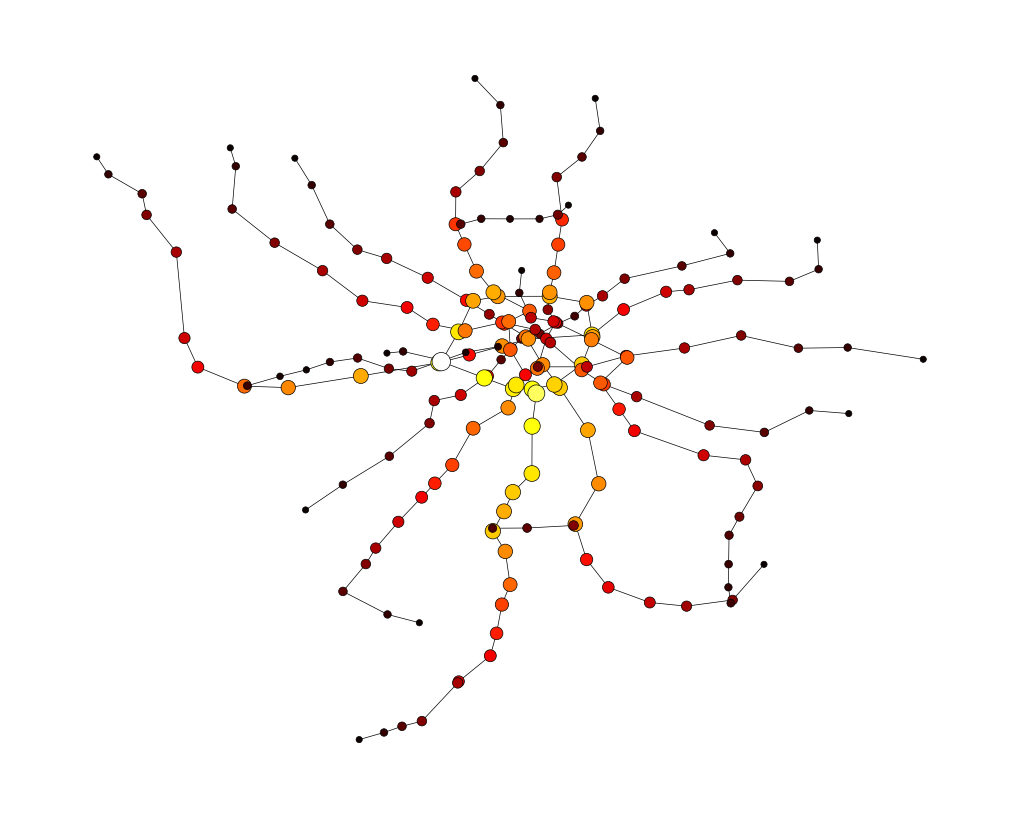

In [21]:
cases = [['degree', 5000, 0, 'Degree centrality'], 
         ['closeness', 700, 0, 'Closeness centrality'], 
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

### Task 3. Center of a graph (0.0 points)

In the next section we will slightly modify the initial graph — truncate all stations that located outside of Sadovoye ring.
Sadovoye ring is the region that includes all stations on the Koltsevaya line, all stations of radial lines that intersect Koltsevaya line and all stations that contains inside the circle.

Write a function `metro_graph_center` that takes a metro graph `G` and returns a subgraph with stations inside Sadovoye ring.

_Hint: use centrality_

In [24]:
def metro_graph_center(G: nx.Graph) -> nx.Graph:
    """
    Build a subgraph with stations inside the Sadovoye ring
    
    :param G: graph of Moscow undeground
    :return: subgraph of Moscow undeground stations that is located inside Sadovoye ring.
    """
    central_nodes = []
    central_nodes = [node for node, cent_val in nx.closeness_centrality(G).items() if cent_val > 0.11]
    return G.subgraph(central_nodes).copy()

In [25]:
'''Check the number of nodes and edges and some random stations'''
subG = metro_graph_center(G)
assert len(subG.nodes) == 57
assert len(subG.edges) == 85
assert 149 in list(subG.nodes)
assert 82 in list(subG.nodes)
assert 137 in list(subG.nodes)

AssertionError: 

Let us draw the center of the metro graph with station names and colors.

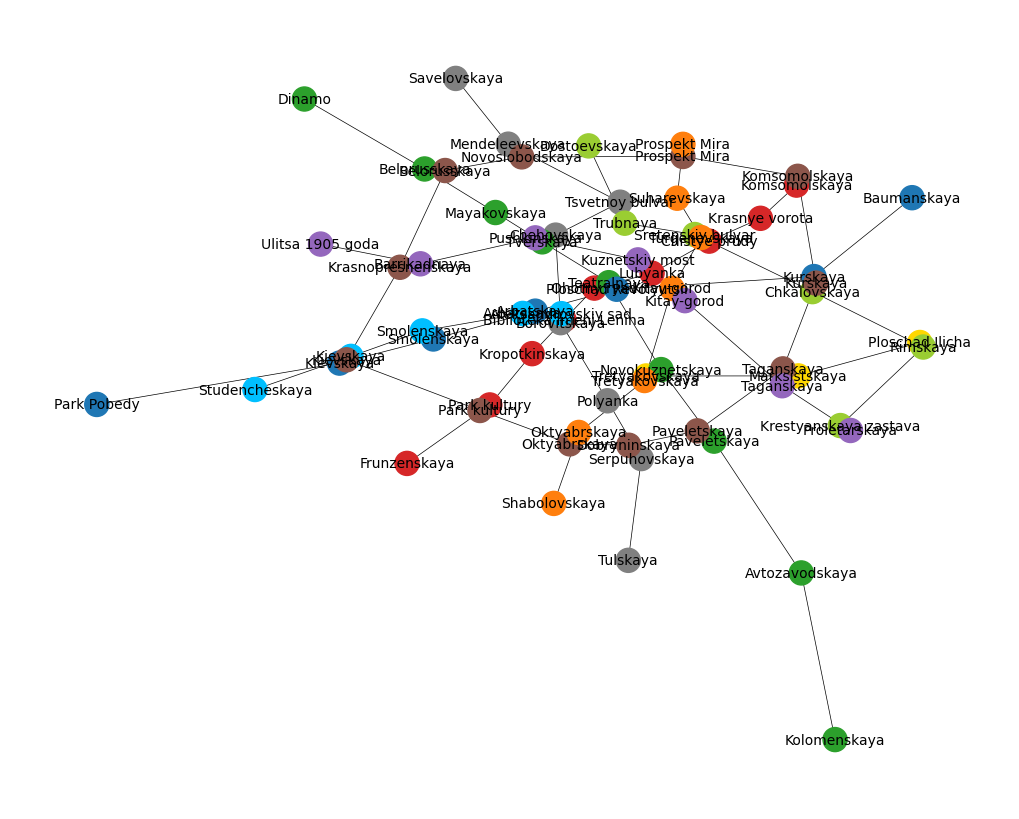

In [26]:
plt.figure(figsize=(10, 8))
nx.draw(subG, 
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(subG, 'color').values()),
        labels=nx.get_node_attributes(subG, 'station_name'),
        font_size=10)
plt.show()

### Task 4. Centrality centralization (2.5 points)

The center of the metro graph looks a bit like a circular graph. We can see that a circular graph has the lowest centralization since

$$\text{Centralization} = \frac{\sum_i^N[C_x(p_*) - C_x(p_i)]}{\max\sum_i^N[C_x(p_*) - C_x(p_i)]}$$

where 
* $C_x$ — some centrality measure
* $p_i$ — $i$-th node
* $p_*$ — node with the largest centrality value
* $\max$ — maximum over all possible graphs with the same number of nodes (a star graph for degree, betweenness, closeness centralities).

Let us check how centralization changes during transformation our truncated graph into a pure circular graph.

Write a function `centralization_seq` that takes the truncated graph `G` and deletes stations except of Koltsevaya line one-by-one in ascending order on node ids (i.e. result of `sorted` function). In each step after removal, the centralization is calculated. The function returns a tuple:
* a dictionary where keys are `degree`, `closeness`, `betweenness` and values are np.arrays with centralization values
* a list of ordered removed nodes

In [ ]:
def centralization_seq(G: nx.Graph) -> (Dict[str, np.array], List[str]):
    

In [ ]:
'''Check the output shape and some random centralization values'''
cent, order = centralization_seq(subG)
assert len(order) == 45
assert order[0] == 5
assert order[-1] == 167
assert cent['degree'].shape == (45,)
assert cent['closeness'].shape == (45,)
assert cent['betweenness'].shape == (45,)
assert cent['degree'][-1] == cent['betweenness'][-1] == cent['closeness'][-1]
assert cent['degree'][41].round(4) == 0.0824
assert cent['degree'][2].round(4) == 0.0406
assert cent['closeness'][11].round(4) == 0.0785
assert cent['closeness'][9].round(4) == 0.0814
assert cent['betweenness'][14].round(4) == 0.1178

Let us draw how the centralization changes when the graph tends to a circular graph.

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cent['degree'], label='Degree')
plt.plot(cent['closeness'], label='Closeness')
plt.plot(cent['betweenness'], label='Betweenness')
plt.ylabel('Centralization')
plt.xlabel('Number of deleted nodes')
plt.axvline(16, linestyle='--', color='C4', alpha=0.5)
plt.axvline(30, linestyle='--', color='C4', alpha=0.5)
plt.axvline(37, linestyle='--', color='C4', alpha=0.5)
plt.axvline(41, linestyle='--', color='C4', alpha=0.5)
plt.legend()
plt.show()

We can see the significant peaks in betweenness centralization. Higher centralization means that centrality measures unevenly distributed over nodes. Betweenness centrality for specific node indicates how much shortest paths pass through this node. Peaks signalize that we break some shortests paths after node deletion, so new shortest paths should go through a little number of specific nodes. Let us visualize graph before and after deletion of a node under index `37` (Tsvetnoy bulvar), to understand this effect.

In [ ]:
plt.figure(figsize=(12, 6))
cases = [[36, [147, 77, 78, 79, 80]], [37, [77, 78, 79, 80]]]
station_names = nx.get_node_attributes(subG, 'station_name')
for i, (node_id, stations) in enumerate(cases):
    plt.subplot(1, 2, i+1)
    s = subG.copy()
    s.remove_nodes_from(order[:node_id + 1])
    betw = nx.betweenness_centrality(s)
    nx.draw(
        s,
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(s, 'color').values()),
        node_size=[(j*60 + 5)**2 for i, j in betw.items()],
        labels={n:v for n, v in station_names.items() if n in stations})
    plt.title('Betweenness centralization: {:.2f}'.format(cent['betweenness'][node_id]))

Tsvetnoy bulvar is a node targeted for deletion on the next step. The node size is betweenness centrality. On the first graph we can see, that exists a cycle of gray and light green line, so all nodes on that lines can easily access each other via shortest path. However, after deletion of Tsvetnoy bulvar, the cycle is broken. So to connect stations between gray and light green lines, it is required to pass through line intersection with Koltsevaya and some stations on it. It raises the value of betwenness centrality for such nodes (e.g. Dobryninskaya, Paveletskaya, Taganskaya, Kurskaya), keeping the old values for the rest of graph. It leads to the increase of overall graph centralization for betwenness centrality.

### Task 5. Eigenvector centrality (2.5 points)

Let us implement eigenvector centrality that can be interpreted as influence of a node. A centrality value of a node takes into account centrality values of its neighbors, that is

$$v_i = \frac{1}{\lambda}\sum_j A_{ij} v_j$$

or in the matrix form

$$Av = \lambda v$$

where $\lambda$ is the largest eigenvalue.

Write a function `eigenvector_centrality` that takes an adjacency matrix `A` and returns a np.array with nonnegative centrality values.

In [ ]:
def eigenvector_centrality(A: np.array) -> np.array:
    """
    Calculate eigenvector centrality
    
    :param A: adjacency matric of graph
    :return: array of eigenvector centralities
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check some random values'''
eig_c = eigenvector_centrality(nx.to_numpy_array(G))
assert np.all(eig_c > 0)
eig_c = eigenvector_centrality(nx.to_numpy_array(subG))
assert np.all(eig_c > 0)
assert eig_c.shape == (57, )
assert eig_c[0].round(4) == 0.0244
assert eig_c[-1].round(4) == 0.0701
assert eig_c[25].round(4) == 0.1198

Let us draw the graph with eigenvector centrality visualization.

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=eig_c/eig_c.max()*400,
        node_color=eig_c)
plt.show()

### Task 6. Katz centrality (2.5 points)

Katz centrality is based on the number of walks (a path that can contain repeated nodes) passing through a node. By the way, how to quickly calculate the total number of fixed length walks between two nodes?

Write a function `number_of_walks` that takes a graph `G`, nodes `i`, `j` and the length of walk `n`. The function returns the number of walks.

In [ ]:
def number_of_walks(G: nx.Graph, i: int, j: int, n: int) -> int:
    """
    Calculate number of paths of length n
    
    :param G: graph of Moscow underground inside the Sadovoye ring
    :param i: the starting node of paths
    :param j: the target node of paths
    :param n: the size of paths
    :return: the number of paths between input nodes of size n
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check some paths in the city center'''
# Paveletskaya (Koltsevaya) - Ohotny ryad. Length 4
# Single path: Paveletskaya (Koltsevaya) -> Paveletskaya (Zamoskvoretskaya) 
# -> Novokuznetskaya -> Teatralnaya -> Ohotny ryad
assert number_of_walks(subG, 78, 9, 4) == 1
# Novoslobodskaya - Pushkinskaya. Length 4
# 1st path: Novoslobodskaya -> Belorusskaya -> Krasnopresnenskaya
# -> Barrikadnaya -> Pushkinskaya
# 2nd path: Novoslobodskaya -> Mendeleevskaya -> Tsvetnoy bulvar
# -> Chehovskaya -> Pushkinskaya
assert number_of_walks(subG, 83, 120, 4) == 2
# Novoslobodskaya - Pushkinskaya. Length 7. Many paths.
assert number_of_walks(subG, 83, 120, 7) == 31

Now we can apply similar approach in calculation Katz centrality. The formula is

$$k_i = \beta\sum_j A_{ij} + \beta^2\sum_j A_{ij}^2 + \beta^3\sum_j A_{ij}^3 + \dots$$

where $\beta$ is an attenuation factor with restriction 

$$\beta < \frac{1}{\lambda}$$

where $\lambda$ is a largest eigenvalue of a matrix $A$.

Write a function `katz_centrality` that takes a graph `G`, number of iterations `n`, attenuation factor `beta` and returns a np.array of centrality values.

In [ ]:
def katz_centrality(G: nx.Graph, n: int, beta: float) -> np.array:
    """
    Calculate Katz centrality
    
    :param G: graph of Moscow undeground
    :param n: number of iterations in Katz centrality calcultation
    :param beta: attenuation factor
    :return: array of centrality values for each node
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check the restriction on beta and networkx implementation'''
beta = 1 / 3
try:
    katz = katz_centrality(G, 1, beta)
except:
    pass
else:
    raise AssertionError("Did not raise an exception")
beta = 1 / 5
assert 0.9999 < np.corrcoef(katz_centrality(G, 1, beta), c['degree'])[0][1] <= 1
nxkatz = np.array([val for val in nx.katz_centrality(G, beta).values()])
assert 0.9999 < np.corrcoef(katz_centrality(G, 20, beta), nxkatz)[0][1] <= 1

Let us draw the graph with Katz centrality visualization.

In [ ]:
katz_c = katz_centrality(subG, 20, 1/4)
katz_c = katz_c / katz_c.max()
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=katz_c*300,
        node_color=katz_c)
plt.show()

Here we can see how Katz centrality converges by the number of iterations.

In [ ]:
plt.figure(figsize=(7, 5))
convergence = []
old_katz = katz_centrality(G, 1, 0.2)
step_space = np.arange(2, 21)
for i in step_space:
    katz = katz_centrality(G, i, 0.2)
    convergence.append(np.linalg.norm(katz - old_katz))
    old_katz = katz.copy()
plt.plot(step_space, convergence)
plt.ylabel('Difference, Euclidean norm')
plt.xlabel('Step')
plt.title('Convergence of Katz centrality')
plt.show()

### Task 7. PageRank algorithm (0.0 points)

Implement PageRank algorithm. A function `page_rank` takes a graph `G`, transition coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.


In [ ]:
'''Do not touch the cell'''
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Write a function `transition_matrix` that takes a np.array with an adjacency matrix `A` and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [ ]:
def transition_matrix(A):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1

Write a function `teleportation_vector` that takes a np.array with an adjacency matrix `A` and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [ ]:
def teleportation_vector(A):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [ ]:
def update_rank(rank, P, v, alpha):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
G = nx.path_graph(6, create_using=nx.DiGraph)
pr = page_rank(G, 0.9, 100)
assert np.all(pr[1:] - pr[:-1] > 0)

Let us draw the graph where node size depends on PageRank.

In [ ]:
graphs = [
    nx.path_graph(6, create_using=nx.DiGraph),
    nx.cycle_graph(6, create_using=nx.DiGraph),
    nx.DiGraph(nx.path_graph(6)),
    nx.erdos_renyi_graph(10, 0.2, directed=True)
]
for G in graphs:
    pr = page_rank(G, 0.9, 100)
    nx.draw_kamada_kawai(
        G,
        with_labels=True,
        node_size=(pr * 1e4),
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)}
    )
    plt.show()

### Task 8. Personalized PageRank (2.5 points)

Personalized PageRank uses a teleportation vector as personal preferences, so that an important node has high probability to jump into it. Personalized PageRank can be considered as a simple recommender system. Consider a dataset of links between some famous painters on Wikipedia. Common PageRank gives us following ranks.

In [ ]:
def plot_painters(G, pr, pref=None):
    if not pref:
        pref = []
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx(
        G, 
        pos, 
        node_size=(pr * 1e4),
        node_color=['tab:red' if G.nodes[n]['name'] in pref else 'tab:blue' for n in G.nodes],
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)})
    nx.draw_networkx_labels(
        G, 
        pos={node: pos[node] + [0, 0.05] for node in pos}, 
        labels=nx.get_node_attributes(G, 'name')
    )
    plt.axis('off')

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
pr = np.array([rank for node, rank in nx.pagerank(G, alpha=0.9).items()])
plt.figure(figsize=(9, 9))
plot_painters(G, pr)
plt.show()

Now let us calculate personalized PageRank based on user's preferences. Construct a teleportation vector so that painters a user likes are proportional to ones and others are zeros.

Write a function `personalized_pr` that takes an argument of common PageRank and a list `pref` that contains names of painters that user likes. The function returns personalized PageRank.

In [ ]:
def personalized_pr(G, alpha, pref, k):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
pref = ['Pablo Picasso', 'Edgar Degas']
pr1 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
pref = ['Edgar Degas']
pr2 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
assert np.isclose(pr1.sum(), 1) and np.isclose(pr2.sum(), 1)
assert pr1[0] > pr2[0]
assert pr1[7] < pr2[7]

In [ ]:
cases = [
    ['Pablo Picasso', 'Edgar Degas'], 
    ['Edgar Degas'], 
    ['Henri Matisse']
]
plt.figure(figsize=(15, 25))
for i, pref in enumerate(cases):
    plt.subplot(3, 2, i*2 + 1)
    plot_painters(G, pr)
    plt.title('PageRank')
    plt.subplot(3, 2, i*2 + 2)
    ppr = personalized_pr(G, alpha=0.9, pref=pref, k=100)
    plot_painters(G, ppr, pref)
    plt.title('Personalized PageRank')

Low transionion coefficient forces to teleport into prefferential nodes and vice versa, so we can adjust the power of preferences changing transionion coefficient.

In [ ]:
pref = ['Pablo Picasso', 'Edgar Degas']
alpha = 0.3
pr = personalized_pr(G, alpha=alpha, pref=pref, k=100)
plt.figure(figsize=(9, 9))
plot_painters(G, pr, pref)